In [6]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score



In [7]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_all.csv')
df.head()

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "평균" 컬럼을 배추가격으로 설정
df = df.rename(columns={'평균':'배추가격'})
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0


In [8]:
# target 컬럼 생성 = "배추가격"
target = df['배추가격']
# feature 컬럼 생성 = "배추가격"을 제외한 모든 컬럼
feature = df.drop('배추가격', axis=1)

# feature 데이터를 0~1 사이의 값으로 정규화
scaler_feature = MinMaxScaler()
feature = scaler_feature.fit_transform(feature)

# target 데이터를 0~1 사이의 값으로 정규화
scaler_target = MinMaxScaler()
target = scaler_target.fit_transform(target.values.reshape(-1,1))
target.shape


(8370, 1)

In [9]:
# feature 데이터를 3차원 배열로 변환
feature = feature.reshape(feature.shape[0], 1, feature.shape[1])
feature.shape


(8370, 1, 3)

In [10]:
# train 데이터와 test 데이터로 분리 (train : test = 8 : 2)
train_size = int(len(feature) * 0.8)
test_size = len(feature) - train_size
train_feature, test_feature = feature[0:train_size,:], feature[train_size:len(feature),:]
train_target, test_target = target[0:train_size,:], target[train_size:len(feature),:]

print(len(train_feature), len(test_feature))

6696 1674


In [11]:
#  lstm 모델 생성
model = Sequential()
model.add(LSTM(50, input_shape=(1, 3)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-23 14:25:12.028978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 14:25:12.029136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [12]:
#  모델 학습 early stopping 적용
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(train_feature, train_target, epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])


Epoch 1/100


2022-12-23 14:25:12.740467: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-23 14:25:13.520042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 14:25:13.677825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 14:25:14.911839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 5s 11ms/step - loss: 0.0088
Epoch 2/100
210/210 [==============================] - 2s 8ms/step - loss: 0.0078
Epoch 3/100
210/210 [==============================] - 2s 9ms/step - loss: 0.0078
Epoch 4/100
210/210 [==============================] - 2s 9ms/step - loss: 0.0078
Epoch 4: early stopping


In [13]:
#  모델 성능 평가
train_predict = model.predict(train_feature)
test_predict = model.predict(test_feature)

# r2 score
print('train r2 score :', r2_score(train_target, train_predict))
print('test r2 score :', r2_score(test_target, test_predict))

# rmse
print('train rmse :', np.sqrt(mean_squared_error(train_target, train_predict)))
print('test rmse :', np.sqrt(mean_squared_error(test_target, test_predict)))


 31/210 [===>..........................] - ETA: 0s

2022-12-23 14:25:23.623321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 14:25:23.664250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 0s 6ms/step
train r2 score : 0.16631677832591296
test r2 score : -0.14828747849062185
train rmse : 0.08781673260542613
test rmse : 0.16614168798150067


In [14]:
# 모델 저장
model.save('model/predict_price_LSTM_withoutPrice.h5')

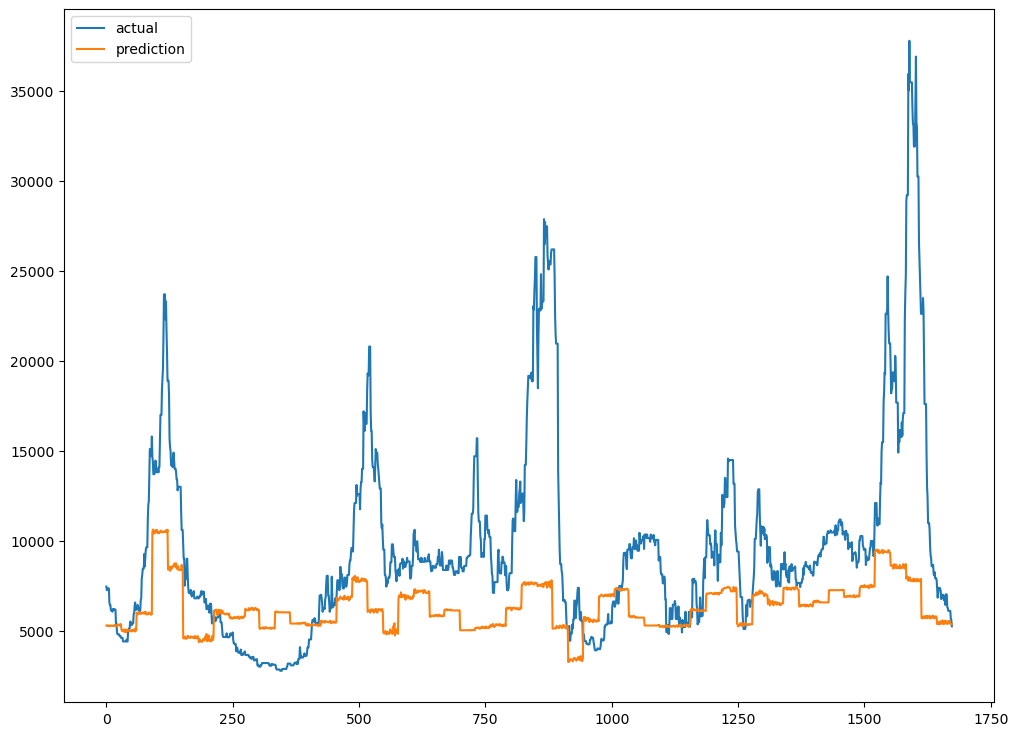

In [15]:
#  예측 결과 시각화
plt.figure(figsize=(12, 9))
plt.plot(scaler_target.inverse_transform(test_target), label='actual')
plt.plot(scaler_target.inverse_transform(test_predict), label='prediction')
plt.legend()
plt.show()


In [16]:
# 예측 결과 저장
# 예측 결과를 원래의 스케일로 변환
test_predict = scaler_target.inverse_transform(test_predict)
# 예측 결과를 데이터프레임으로 변환
test_predict = pd.DataFrame(test_predict, columns=['예측가격'])
test_predict

,예측가격
0,5285.538086
1,5272.662598
2,5286.544434
3,5270.576660
4,5270.576660
...,...
1669,5398.330078
1670,5398.330078
1671,5381.209961
1672,5359.367676


새로운 데이터 사용

In [17]:
# read price_baechoo.csv
price_new = pd.read_csv('data/price/price_baechoo.csv')
# 2022년 12월 데이터만 추출
price_new = price_new[price_new['구분'].str.contains('2022-12')]
# "구분" 컬럼을 인덱스로 설정
price_new = price_new.set_index('구분')
# "평균" 컬럼을 배추가격으로 설정
price_new = price_new.rename(columns={'평균':'배추가격'})
price_new.head()


,배추가격
구분,
2022-12-01,5462.0
2022-12-05,5982.0
2022-12-06,5502.0
2022-12-07,5488.0
2022-12-08,5408.0


In [18]:
#  price_new 가 새로운 target 데이터이다
#  새로운 target 데이터를 0~1 사이의 값으로 정규화
scaler_new_target = MinMaxScaler()
price_new_scaler = scaler_new_target.fit_transform(price_new)

#  새로운 target 데이터를 3차원 배열로 변환
price_new_3d = price_new_scaler.reshape(price_new_scaler.shape[0], price_new_scaler.shape[1], 1)

#  새로운 target 데이터를 예측
new_predict = model.predict(price_new_3d)  
#  예측 결과를 원래의 스케일로 변환
new_predict = scaler_target.inverse_transform(new_predict)

#  예측 결과를 데이터프레임으로 변환
new_predict = pd.DataFrame(new_predict, columns=['예측가격'])
new_predict

2022-12-23 14:25:25.377914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 14:25:25.420042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 412ms/step


,예측가격
0,3012.468994
1,1333.251953
2,2878.194336
3,2925.121338
4,3194.634033
5,3194.634033
6,3750.834229
7,3747.417236
8,3118.615967
9,3118.615967


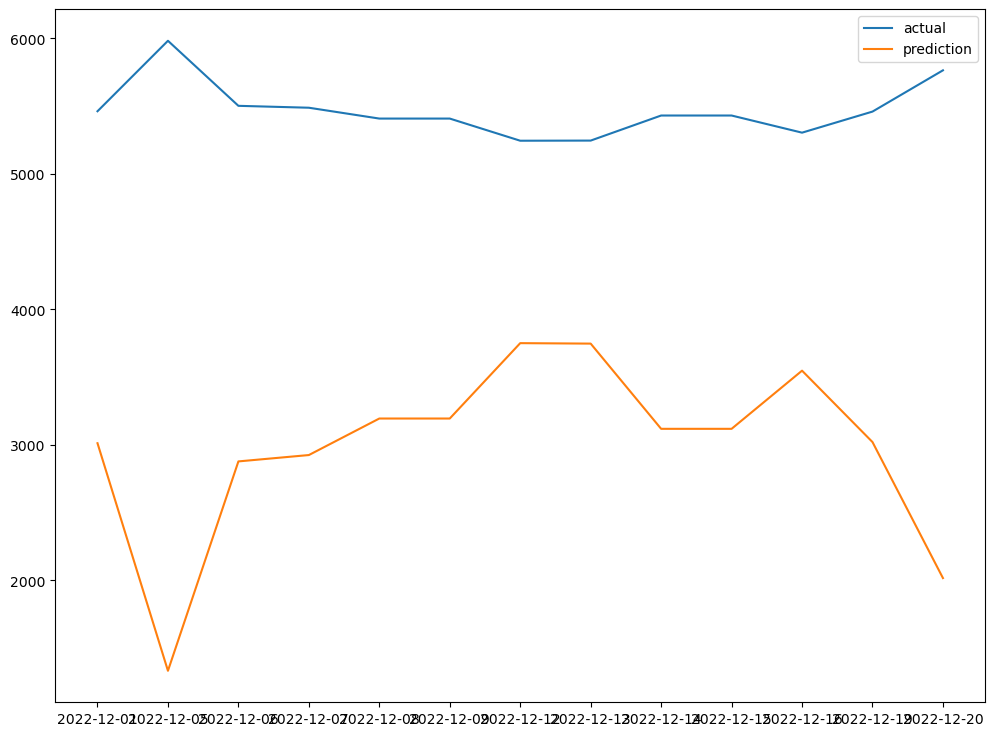

In [19]:
#  예측 결과 시각화
plt.figure(figsize=(12, 9))
plt.plot(price_new, label='actual')
plt.plot(new_predict, label='prediction')
plt.legend()
plt.show()

In [21]:
# r2 score
print('r2 score :', r2_score(price_new, new_predict))

# rmse
print('rmse :', np.sqrt(mean_squared_error(price_new, new_predict)))


r2 score : -180.94322221211357
rmse : 2617.9255503405984
